# 1 Umiddelbare overvejelser omkring data?

Jeg har fået et dataset af film/serier, jeg bemærket at movie_id's har "tt" i ID'et, det giver mig en ide om at det nok er ID's der ikke er generet i datasettet, men formentligt kommer fra IMDB. Oftes er ID'er integers. Jeg bemærkede ligeledes, hvordan filmene er reduceret til 1 genre. På hjemmesiden IMDB kategoriseres størstedelen af filmene i flere genre. Dette kan påvirke resultatet i en model, eftersom man "reducerer" en film til én genre. Hvis man havde flere genre ville man kunne bruge MultiLabelBinarizer i sklearn til at "samle" en films genre til et array som kan bruges til at klassificere en film med flere genre effektivt. 

# 2 Put data ned i en database

Først køres følgende SQL kode i mariadb for at opsætte databasen og tables:
```
CREATE DATABASE IF NOT EXISTS imdb_movies_db;
USE imdb_movies_db;

CREATE TABLE IF NOT EXISTS Movies (
    movie_id INT PRIMARY KEY,
    title VARCHAR(255),
    description TEXT,
    genre VARCHAR(255)
);
```

In [29]:
import mariadb
import sys
# -- insert your own database credentials here --
db_config = {
    'user': 'root',
    'password': 'password',
    'host': 'localhost',
    'port': 3306,
    'database': 'imdb_movies_db'
}

def connect_to_db():
    try:
        conn = mariadb.connect(**db_config)
        return conn

    except mariadb.Error as e:
        print(f"Error connecting to MariaDB Platform: {e}")
        sys.exit(1)

Bruger mariadb og pandas til at putte data ned i en database.

In [30]:
import pandas as pd
import re

conn = connect_to_db()
cur = conn.cursor()

df = pd.read_csv('IMDB_larger_description_dataset.csv')

# Drop empty rows
df.dropna(subset=["movie_id"], inplace=True)
df.dropna(subset=["description"], inplace=True)

# remove tt from movie_id, as it is not needed
df['movie_id'] = df['movie_id'].apply(lambda x: re.sub('tt', '', x))
print(df.head())

for _, row in df.iterrows():
    cur.execute(
        "INSERT INTO Movies (movie_id, description, genre) VALUES (%s, %s, %s)",
        (row['movie_id'], row['description'], row['genre'])
    )

conn.commit()
cur.close()
conn.close()

   movie_id                                        description    genre
0  12783454  Elle Evans (Joey King) has finally completed h...  romance
1   1798632  A young girl tries to understand how she myste...   horror
2   9214832  In 1800s England, a well meaning but selfish y...   comedy
3   8522006  Abby Holland (Kristen Stewart) and Harper Cald...  romance
4  21249656  Olga and Maks are 15 years apart. She is a suc...  romance


Pandas har ikke direkte support til mariadb, derfor bruger jeg sqlalchemy for at kunne få pandas til at arbejde sammen med mariadb

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

connection_string = f"mariadb+mariadbconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

conn = engine.connect()

df = pd.read_sql("SELECT * FROM movies", engine)

dfcpy = df.copy() 
# Adding leading zeros to movie_id
dfcpy['movie_id'] = dfcpy['movie_id'].apply(lambda x: f"{x:07d}")

# Checking that the data is loaded correctly into database and out into dataframe
print(dfcpy.head())

engine.dispose()

  movie_id title                                        description    genre
0  0059742  None  Maria always wanted to be a nun ever since she...  romance
1  0068935  None  A man visits his relatives at their restaurant...   action
2  0070034  None  A Shaolin martial artist travels to an island ...   action
3  0070849  None  A young Parisian woman meets a middle-aged Ame...  romance
4  0092720  None  After the renewed flings with their former lov...  romance


# 3 Hvad er fordelingen af genre? 
   - Hvor mange film/serier der er i hver genre?
   - Diskuter ganske kort fordele og ulemper ved den fundne genre fordeling.

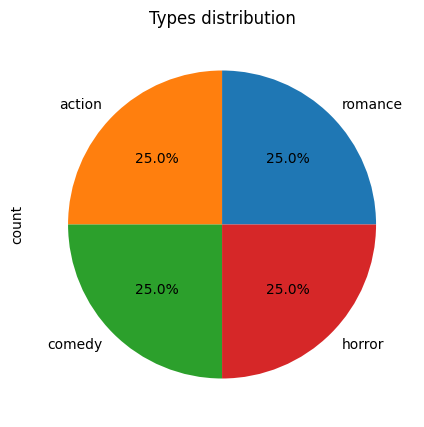

In [46]:
dfcpy.genre.value_counts().plot.pie(autopct='%1.1f%%', figsize=(10,5), title='Types distribution')
plt.show()

Der er 1000 film/serier i datasættet og der er 250 film/serier i hver genre, det betyder at datasættet er helt balanceret i forhold til genre. Det har den fordel at modellen bliver trænet på samme mængde film i hver genre. Det betyder at vores model ikke bliver biased imod en bestemt genre. Denne fordeling af film på tværs af genre betyder ikke at vores data er perfekt. Det er vigtigt at overveje om de film der er blevet udvalgt i hver genre til træning af model er gode og repræsentative for den genre. Sproget der bliver brugt i film beskrivelserne har en stor effekt på hvor god modellen vi træner bliver. Ord som "kill" og "fight" i film beskrivelsen er ord som kunne give en indikation om filmens genre. Vi kan derfor opleve at en genre som komedie bliver svær at klassificere, fordi ordene der bliver brugt i beskrivelser af komediefilm ikke er mærkværdige eller unikke derfor er der ikke noget  der får beskrivelser af komediefilm til stå ud fra i forhold til andre beskrivelser af film i andre genre.

# 4 Lav en klassifikationsmodel 

**Vores data skal renses for at kunne blive brugt effektivt i vores modeller. Til det har jeg brugt følgende pipeline:**
- cleantext: tal, linjeskift og datoer bliver udskiftet med tokens. 
- stop word removal: stopord som "er, et den, de, os, at, på, i" fjernes da de ikke giver mening at medtage i vores model og har ingen værdi for vores model.
- stemming: ord bliver "normaliseret", ord bliver reduceret til deres "rodform", enelser bliver fjernet osv. 
- tokenization: ord bliver lagt i en liste hvor elementer i listen er ord. 

In [47]:
import re
import nltk
# nltk.download('punkt') ## skal kun køres en gang
# nltk.download('stopwords') ## skal kun køres en gang
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer
from cleantext import clean

def clean_text(text):
  clean_text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
  clean_text = clean(clean_text,
    lower=True,
    no_numbers=True, replace_with_number= r"<NUM>",
    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
    no_punct=True, replace_with_punct="",
    no_line_breaks=True 
  )
  return clean_text

def rmv_stopwords(tokens):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

def stem_tokens(tokens):
  stemmer=PorterStemmer()
  Output=[stemmer.stem(word) for word in tokens]
  return Output

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')

In [50]:
from sklearn.model_selection import train_test_split


dfcpy['description'] = dfcpy['description'].apply(clean_text)
dfcpy['description'] = dfcpy['description'].apply(tokenizer.tokenize)
dfcpy['description'] = dfcpy['description'].apply(rmv_stopwords)
dfcpy['description'] = dfcpy['description'].apply(stem_tokens)

# joining tokens back together
dfcpy['description'] = dfcpy['description'].apply(lambda x: ' '.join(x))
print(dfcpy.head())

X = dfcpy['description']

y = dfcpy['genre']

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  movie_id title                                        description    genre
0  0059742  None  maria alway want nun ever sinc littl girl grew...  romance
1  0068935  None  man visit rel restaur itali help defend brutal...   action
2  0070034  None  shaolin martial artist travel island fortress ...   action
3  0070849  None  young parisian woman meet middleag american bu...  romance
4  0092720  None  renew fling former lover prove disastr unlik r...  romance


Ord i filmbeskrivelser bliver lavet til numeriske vektorer til model træning. Bruger TFIDF da det bla. tager højde for unikhed af ord. 

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

tfidf = TfidfVectorizer(token_pattern=r'<[\w]+>|[\w]+')
scaler = StandardScaler(with_mean=False)

pipe = Pipeline([
    ('tfidf', tfidf),
    ('scaler', scaler) 
])

X_train_TFIDF = pipe.fit_transform(X_train)
X_test_TFIDF = pipe.transform(X_test)

Først kører jeg 2 forskellige modeller jeg har en ide om kunne være gode til den her slags opgave:
- Naive Bayes model
- Support vector machine (med linear kerne)

Naive bayes kan være god til når man har mindre mængder af data eftersom den kan håndtere et feature space i høje dimensioner uden at behøve mange observationer (hvilket er en fordel når vi ikke har meget data at kigge på). Den har også ofte mindre varians og der er derfor en mindre sandsynlighed for at modellen bliver overfittet. 

Support vector machine(SVM) er en model som generelt er rigtig god til tekst klassificering, især fordi den bruger regularization til at undgå overfitting når vi har få samples (film), men mange features (dimensionen i TFIDF vektor). Jeg ved også at SVM er brugt meget til tekst klassificerings opgaver som: spam dectection eller kategorisering af dokumenter. 

Jeg overvejet også et nerual network, men de er ofte ikke så gode hvis man ikke har meget data, udover det så tager de også lang tid at træne og kræver en del computerkraft.


In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# train the model
model = MultinomialNB()
model.fit(X_train_TFIDF, y_train)
y_pred = model.predict(X_test_TFIDF)
NB_results = metrics.classification_report(y_test, y_pred)

In [65]:
from sklearn.svm import LinearSVC
import sklearn.metrics as metrics

model = LinearSVC(random_state=42)
model.fit(X_train_TFIDF, y_train)
y_pred = model.predict(X_test_TFIDF)
SVM_results = metrics.classification_report(y_test, y_pred)

# 5 Præsenter resultaterne.

In [66]:
print("Naive Bayes results:")
print(NB_results)
print("Support vector machine results:")
print(SVM_results)

Naive Bayes results:
              precision    recall  f1-score   support

      action       0.58      0.35      0.44        51
      comedy       0.36      0.55      0.43        47
      horror       0.65      0.44      0.53        54
     romance       0.36      0.44      0.39        48

    accuracy                           0.45       200
   macro avg       0.49      0.45      0.45       200
weighted avg       0.49      0.45      0.45       200

Support vector machine results:
              precision    recall  f1-score   support

      action       0.73      0.71      0.72        51
      comedy       0.50      0.47      0.48        47
      horror       0.74      0.63      0.68        54
     romance       0.52      0.67      0.59        48

    accuracy                           0.62       200
   macro avg       0.62      0.62      0.62       200
weighted avg       0.63      0.62      0.62       200



Support vector machine klarer sig bedst i forhold til accuracy, derfor forsøger jeg at forbedre den. 

Vi ser at f1 scoren er højere på action og gyserfilm, det kan være fordi ordene der bruges til at beskrive den slags film er mere unik end andre genre. Lad os kigge på de mest hyppige ord i filmbeskrivelser af en bestemt genre:

## Hyppighed af ord kan være med til at forklare model resultater

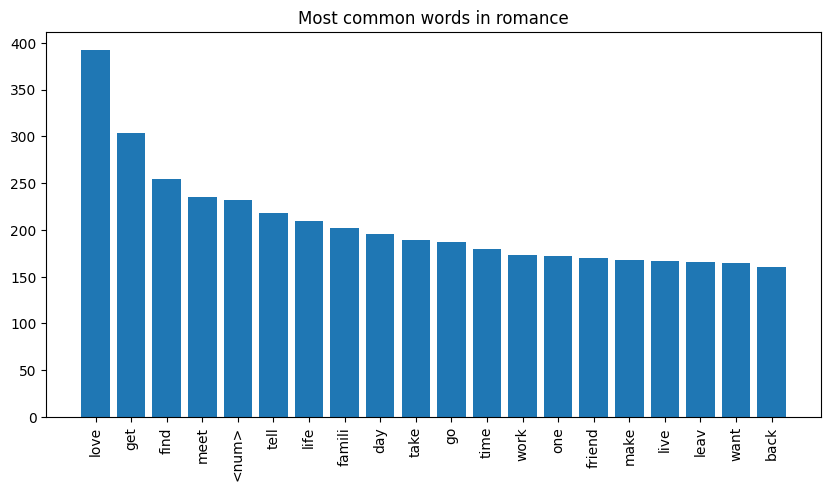

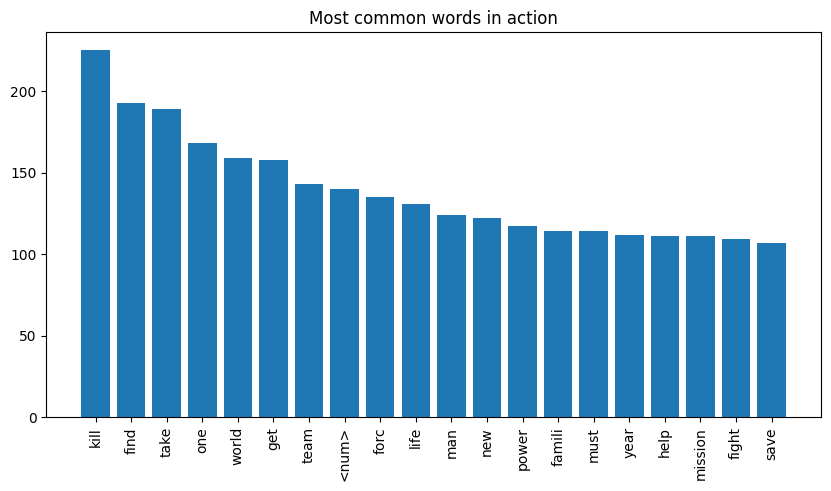

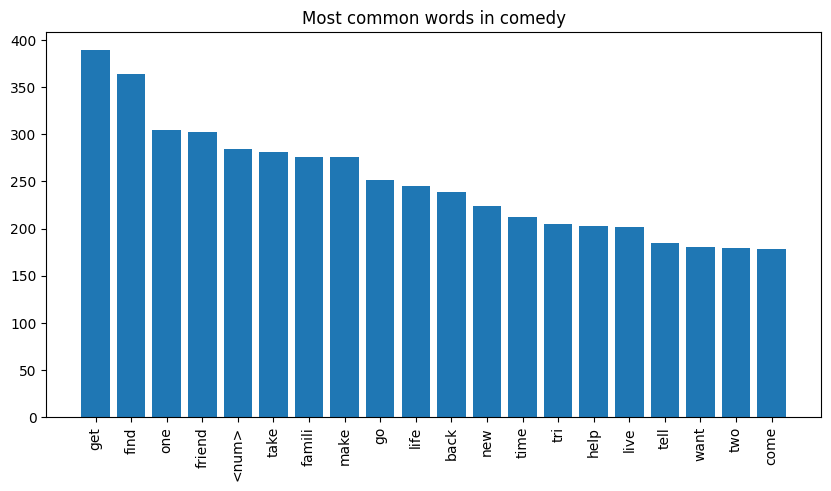

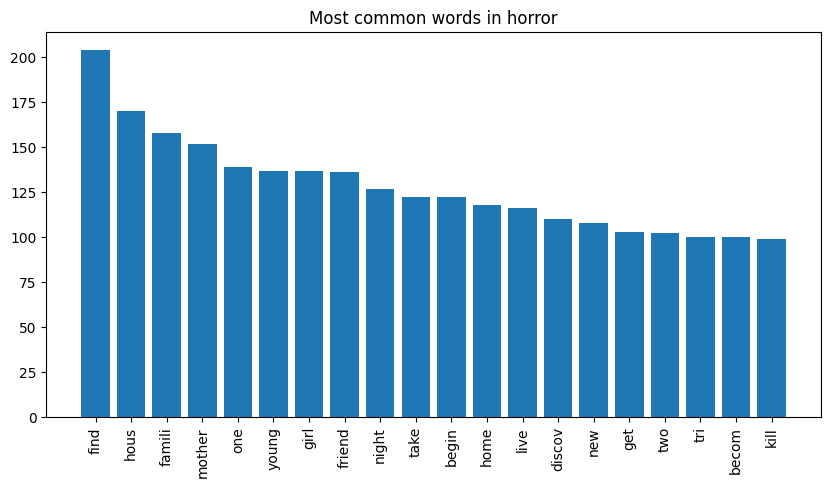

In [55]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_most_common_words(genre, df):
    genre_df = df[df['genre'] == genre]
    all_words = ' '.join(genre_df['description']).split()
    counter = Counter(all_words)
    most_common = counter.most_common(20)
    words = [word[0] for word in most_common]
    counts = [word[1] for word in most_common]
    plt.figure(figsize = (10, 5))
    plt.xticks(rotation = 90, fontsize = 10)
    plt.bar(words, counts)
    plt.title(f'Most common words in {genre}')
    plt.show()

for genre in dfcpy['genre'].unique():
    plot_most_common_words(genre, dfcpy)

Man kan se på graferne at ord som "kill", "power", "mission", "fight", "hous" "mother" og "save" bliver brugt ofte, men er unikke til gyserfilm og actionfilm, det kan være med til at forklare hvorfor gyser og action har en høj f1-score (de bliver klassificeret korrekt ofte). ord som "find" bliver brugt i alle film beskrivelser og derfor kan det ikke hjælpe modellerne meget til at klassificere film.

# 6 Hvad kan gøre resultaterne bedre

## Forslag 1: Brug crossvalidation og tune hyperparameters
Support vector machine modellen klaret sig bedre en naive Bayes modellen, men det var stadig ikke gode resultater. Resultaterne kan bla. forbedres ved at bruge cross validation og gridsearch til at finde de bedste parametre til vores TF-IDF vektorer og SVM. Her bruger jeg sklearn GridSearchCV som laver cross validation og finder de bedste parametre til vores model.  


## Forslag 2: Mere data
En anden måde vi kan forbedre vores model er ved at få mere data. Hvis vi har mere data kan vi forvente at se en forbedring i model resultater, men det kan også skabe problemer hvis den data man tilføjer ikke er god. Hvis der tilføjes en masse film i én genre får vi potentielt en bias i vores model (det kan dog potentielt undgås ved at bruge oversampling), yderligere skal de film der tilføjes også have gode  beskrivelser der er giver en tydelig indikation for filmens genre. Jeg opdaget at IMDB ikke tillader scraping uden en API key, som man skal købe, der er open source alternativer, men de er meget begrænset i mængden af data man kan scrape per dag. Man kunne finde andre dataset med IMDB film, men jeg fandt det ikke passende at bruge nye dataset. Derfor endte jeg ikke med at tilføje ny data og prøver i stedet at forbedre modellen med første forslag

# 7 Gør modellen bedre
Her gør jeg brug af GridSearch til at finde den bedste model hyperparameters og til at finde den bedste vektor repræsentation (n-grams)

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
import joblib


pipe = Pipeline([
    ('tfidf', TfidfVectorizer(token_pattern=r'<[\w]+>|[\w]+', min_df=1, max_df=0.9)),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LinearSVC(random_state=42))
])

# tuning hyperparameters
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
    'model__C': [0.001 ,0.1, 1, 10, 100]
}

grid = GridSearchCV(pipe, param_grid, cv=3)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)
SVM_results = metrics.classification_report(y_test, y_pred)
print("Support vector machine results:")
print(SVM_results)

# save the model
joblib.dump(grid, 'model.joblib')

{'model__C': 0.001, 'tfidf__ngram_range': (1, 2)}
Support vector machine results:
              precision    recall  f1-score   support

      action       0.83      0.78      0.81        51
      comedy       0.69      0.43      0.53        47
      horror       0.71      0.78      0.74        54
     romance       0.66      0.88      0.75        48

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.71       200
weighted avg       0.72      0.72      0.71       200



['model.joblib']

Jeg formår at forbedre resultaterne en smule, jeg ser blandt andet at romantiske film nu oftere bliver klassificeret korrekt, det skyldes formentligt at jeg bruger (1,2) gram i TF-IDF, hvilket giver mere kontekst til ord i modellen.

# 8 Få navne på filmene?

Jeg opdaget at movie_ids var taget fra IMDB, jeg vidste derfor også at vi nemt kunne finde film navne ved at bruge dette movie_id. Jeg ville bruge IMDB's egen API, men eftersom man skulle betale for en API key var jeg nødsaget til at finde et open source alternativ: OMDBAPI, der giver gratis API keys som er begrænset til 1000 forespørgsler per dag. I dette tilfælde har vi movie_ids som gør det meget nemt at få navne på filmene, men man kunne også sagtens bruge filmbeskrivelserne, her ville man istedet for sende en search request til API'en og give filmbeskrivelsen.

In [58]:
import requests
# using the OMDB API to get movie titles from movie ids
def get_movie_title(movie_id, api_key):
    ## adding tt back to movie_id
    url = f'http://www.omdbapi.com/?i=tt{movie_id}&apikey={api_key}'
    response = requests.get(url)
    if response.status_code == 200: # OK
        data = response.json()
        if 'Title' in data:
            return data['Title']
        else:
            print(f"Error: {data['Error']}")
            return "NULL"
    else:
        print(f"Error: {response.status_code}")
        return "NULL"

conn = connect_to_db()
cur = conn.cursor()

# use movie ids from database to get movie titles
cur.execute("SELECT movie_id FROM movies")
movie_ids = cur.fetchall()

api_key = "783bf62c" # insert your own OMDB API key here, IMDB API key is not free

for movie_id in movie_ids:
    # zero pad movie ids so they are at least 7 digits long (IMDB format)
    formatted_movie_ids = f"{movie_id[0]:07d}"
    title = get_movie_title(formatted_movie_ids, api_key)
    cur.execute("UPDATE movies SET title = ? WHERE movie_id = ?", (title, formatted_movie_ids))

cur.execute("UPDATE movies SET title = NULL WHERE title = 'NULL'")

conn.commit()
cur.close()
conn.close()

The Sound of Music
The Way of the Dragon
Enter the Dragon
Last Tango in Paris
Capriccio
The Simpsons
Paprika
Northern Exposure
Seinfeld
All Ladies Do It
Fist of Legend
The Voyeur
Stealing Beauty
Lolita
Titanic
Family Guy
Romance
Malena
Hera Pheri
Sex and Lucía
The Piano Teacher
Intimacy
Mortal Kombat
The Dreamers
The Notebook
Eternal Sunshine of the Spotless Mind
Anatomy of Hell
One Tree Hill
Fallo!
Mean Girls
The Office
Gossip Girl
9 Songs
Lie with Me
Phir Hera Pheri
Terminator Salvation
The Flash
It's Always Sunny in Philadelphia
Monamour
Welcome
Golmaal: Fun Unlimited
Without Remorse
Bhagam Bhag
The Witches
Heyy Babyy
Dhamaal
Terminator: The Sarah Connor Chronicles
Jungle Cruise
Hellraiser
Fantasy Island
Army of the Dead
Dhol
The Last Voyage of the Demeter
All Quiet on the Western Front
The Invisible Man
Bill & Ted Face the Music
Golmaal Returns
The Killer
Dune
Room in Rome
The Hustle
In the Heights
Terminator Genisys
Tom & Jerry
All the Best: Fun Begins
Modern Family
Indiana Jones 

In [62]:
conn = connect_to_db()
cur = conn.cursor()

# check that the titles are loaded correctly
cur.execute("SELECT movie_id, title, genre FROM Movies")
rows = cur.fetchall()
for i in range(10):
    print(rows[i])
    
# last movie had error 401, so it is NULL
print(rows[-1])
conn.commit()
cur.close()
conn.close()


(59742, 'The Sound of Music', 'romance')
(68935, 'The Way of the Dragon', 'action')
(70034, 'Enter the Dragon', 'action')
(70849, 'Last Tango in Paris', 'romance')
(92720, 'Capriccio', 'romance')
(96697, 'The Simpsons', 'comedy')
(98063, 'Paprika', 'romance')
(98878, 'Northern Exposure', 'comedy')
(98904, 'Seinfeld', 'comedy')
(104014, 'All Ladies Do It', 'romance')
(29079885, None, 'romance')


En af filmene: tt29079885 var ikke mulig at få navn på, da jeg prøvede at få filmens navn fik jeg en error 401: Unauthorized. Det er formentligt et problem med min API key.

# Ekstra: Det er spændende at altid have de nyeste film i databasen! Hvordan gør vi det?
- Undersøg forskellige måder at tilføje de nyeste film, så vi hver dag kl 11:55 bliver opdateret (så kan vi diskutere dem over frokosten)
- Diskuter fordele og ulemper ved hver metode. 
- Implementer dit løsningsforslag.
- Skal modellen gentrænes dagligt med de nye film?

Hvis vi antager at databasen ligger på en server kan vi bruge "cron" til Linux eller "Task Scheduler" på Windows til at køre et script der opdaterer databasen. I Linux ville man tilføje følgende linje til crontab for at køre scriptet dagligt 11:55:

$ 55 11 * * * python3 /path_to_script.py

Scriptet ville være relativt simpelt, man ville ideelt lave et kald til IMDB's API. Her ville man kunne scrape film efter udgivelsesdato. Det kunne yderligere være en idé at tilføje udgivelsesdatoen til databasen så man også kan se hvornår filmen blev udgivet. Yderligere ville jeg foreslå at man tilføjede alle genrer til en film, så film ikke blot har en genre. Det ville også være smart at få ændret de nuværende film i databasen så de også har flere genrer og udgivelsesdato. En ny kolonne kunne nemt tilføjes til vores database:
```
ALTER TABLE Movies
ADD COLUMN release_date VARCHAR(255);
```
Ulempen ved at gøre det på denne måde er at man er nødsaget til at bruge IMDB's API som man skal betale for. Man kunne formentligt godt bruge cloud computing til at løse denne opgave, men jeg har ikke noget erfaring med cloud computing, så det kan jeg ikke udtale mig om. Man kunne måske overveje om det er alle film man har lyst til at få ind i databasen, evt. kunne man kun indsætte film med engelsk eller dansk tale.  

Hvis man tilføjer flere genrer til en film skal modellen ændres og gentrænes for at kunne klassificere multilabel data (flere genre labels) korrekt, men man ville ikke være nødsaget til at gentræne modellen hver dag. Man ville i stedet teste modellen hver dag og hvis man bemærker at kvaliteten af modellen (accuracy og f1-score) falder under en bestemt grænse, kan man så gentræne modellen. Nu er dette dataset også relativt småt, hvis vi forestiller os at vores dataset bliver tilstrækkelig stort, kunne man også overveje at bruge et neuralt netværk i stedet. Et neuralt netværk kan give gode resultater til denne slags opgaver, men kræver også meget data.

**Her er et udkast til et script man kunne bruge til at opdatere filmdatabasen dagligt**

In [ ]:
def fetch_latest_movies():
    response = requests.get(IMDB_API_URL)
    response.raise_for_status()
    if response.status_code == 200:
        return response.json()
    else:
        return None

def add_new_movies(cursor, movies):
    for movie in movies:
        cursor.execute(
            "INSERT INTO movies (id, title, plot, genre, realese_date) VALUES (?, ?, ?, ?, ?)", 
            (movie['id'], movie['title'], movie['plot'], movie['genre'], movie['realese_date']))


def main():
    # Connect to the database
    conn = connect_to_db()
    cursor = conn.cursor()

    
    movies = fetch_latest_movies()
    if movies is None:
        print("No new movies found")
        conn.close()
        return
    
    add_new_movies(cursor, movies)

    conn.commit()
    conn.close()

if __name__ == '__main__':
    main()